In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

# Path ke file di Google Drive (pastikan sesuai dengan lokasi file Anda)
train_file_path = 'aug_train.csv'
test_file_path = 'aug_test.csv'

# Baca file CSV dari Google Drive
df_train = pd.read_csv(train_file_path)
df_test = pd.read_csv(test_file_path)

# Data Training (aug_train)

In [3]:
df_train

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19153,7386,city_173,0.878,Male,No relevent experience,no_enrollment,Graduate,Humanities,14,NaN,NaN,1,42,1.0
19154,31398,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,NaN,NaN,4,52,1.0
19155,24576,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,50-99,Pvt Ltd,4,44,0.0
19156,5756,city_65,0.802,Male,Has relevent experience,no_enrollment,High School,NaN,<1,500-999,Pvt Ltd,2,97,0.0


In [4]:
df_train.isnull().sum()

enrollee_id                  0
city                         0
city_development_index       0
gender                    4508
relevent_experience          0
enrolled_university        386
education_level            460
major_discipline          2813
experience                  65
company_size              5938
company_type              6140
last_new_job               423
training_hours               0
target                       0
dtype: int64

In [5]:
df_train.dtypes

enrollee_id                 int64
city                       object
city_development_index    float64
gender                     object
relevent_experience        object
enrolled_university        object
education_level            object
major_discipline           object
experience                 object
company_size               object
company_type               object
last_new_job               object
training_hours              int64
target                    float64
dtype: object

In [6]:
df_train.describe()

,enrollee_id,city_development_index,training_hours,target
count,19158.000000,19158.000000,19158.000000,19158.000000
mean,16875.358179,0.828848,65.366896,0.249348
std,9616.292592,0.123362,60.058462,0.432647
min,1.000000,0.448000,1.000000,0.000000
25%,8554.250000,0.740000,23.000000,0.000000
50%,16982.500000,0.903000,47.000000,0.000000
75%,25169.750000,0.920000,88.000000,0.000000
max,33380.000000,0.949000,336.000000,1.000000


In [7]:
numerik = df_train.select_dtypes(include=['number'])
kategorikal = df_train.select_dtypes(include=['object'])

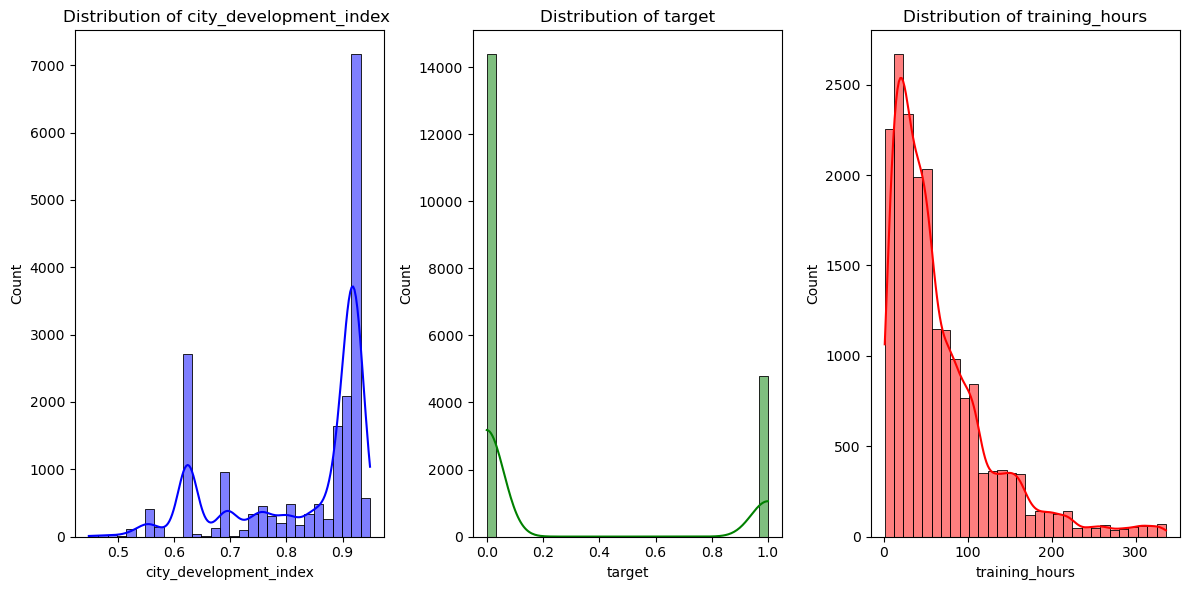

In [8]:
# Visualisasi data numerical
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
sns.histplot(numerik['city_development_index'], kde=True, color='blue', bins=30)
plt.title('Distribution of city_development_index ')

plt.subplot(1, 3, 2)
sns.histplot(numerik['target'], kde=True, color='green', bins=30)
plt.title('Distribution of target')

plt.subplot(1, 3, 3)
sns.histplot(numerik['training_hours'], kde=True, color='red', bins=30)
plt.title('Distribution of training_hours')

plt.tight_layout()
plt.show()


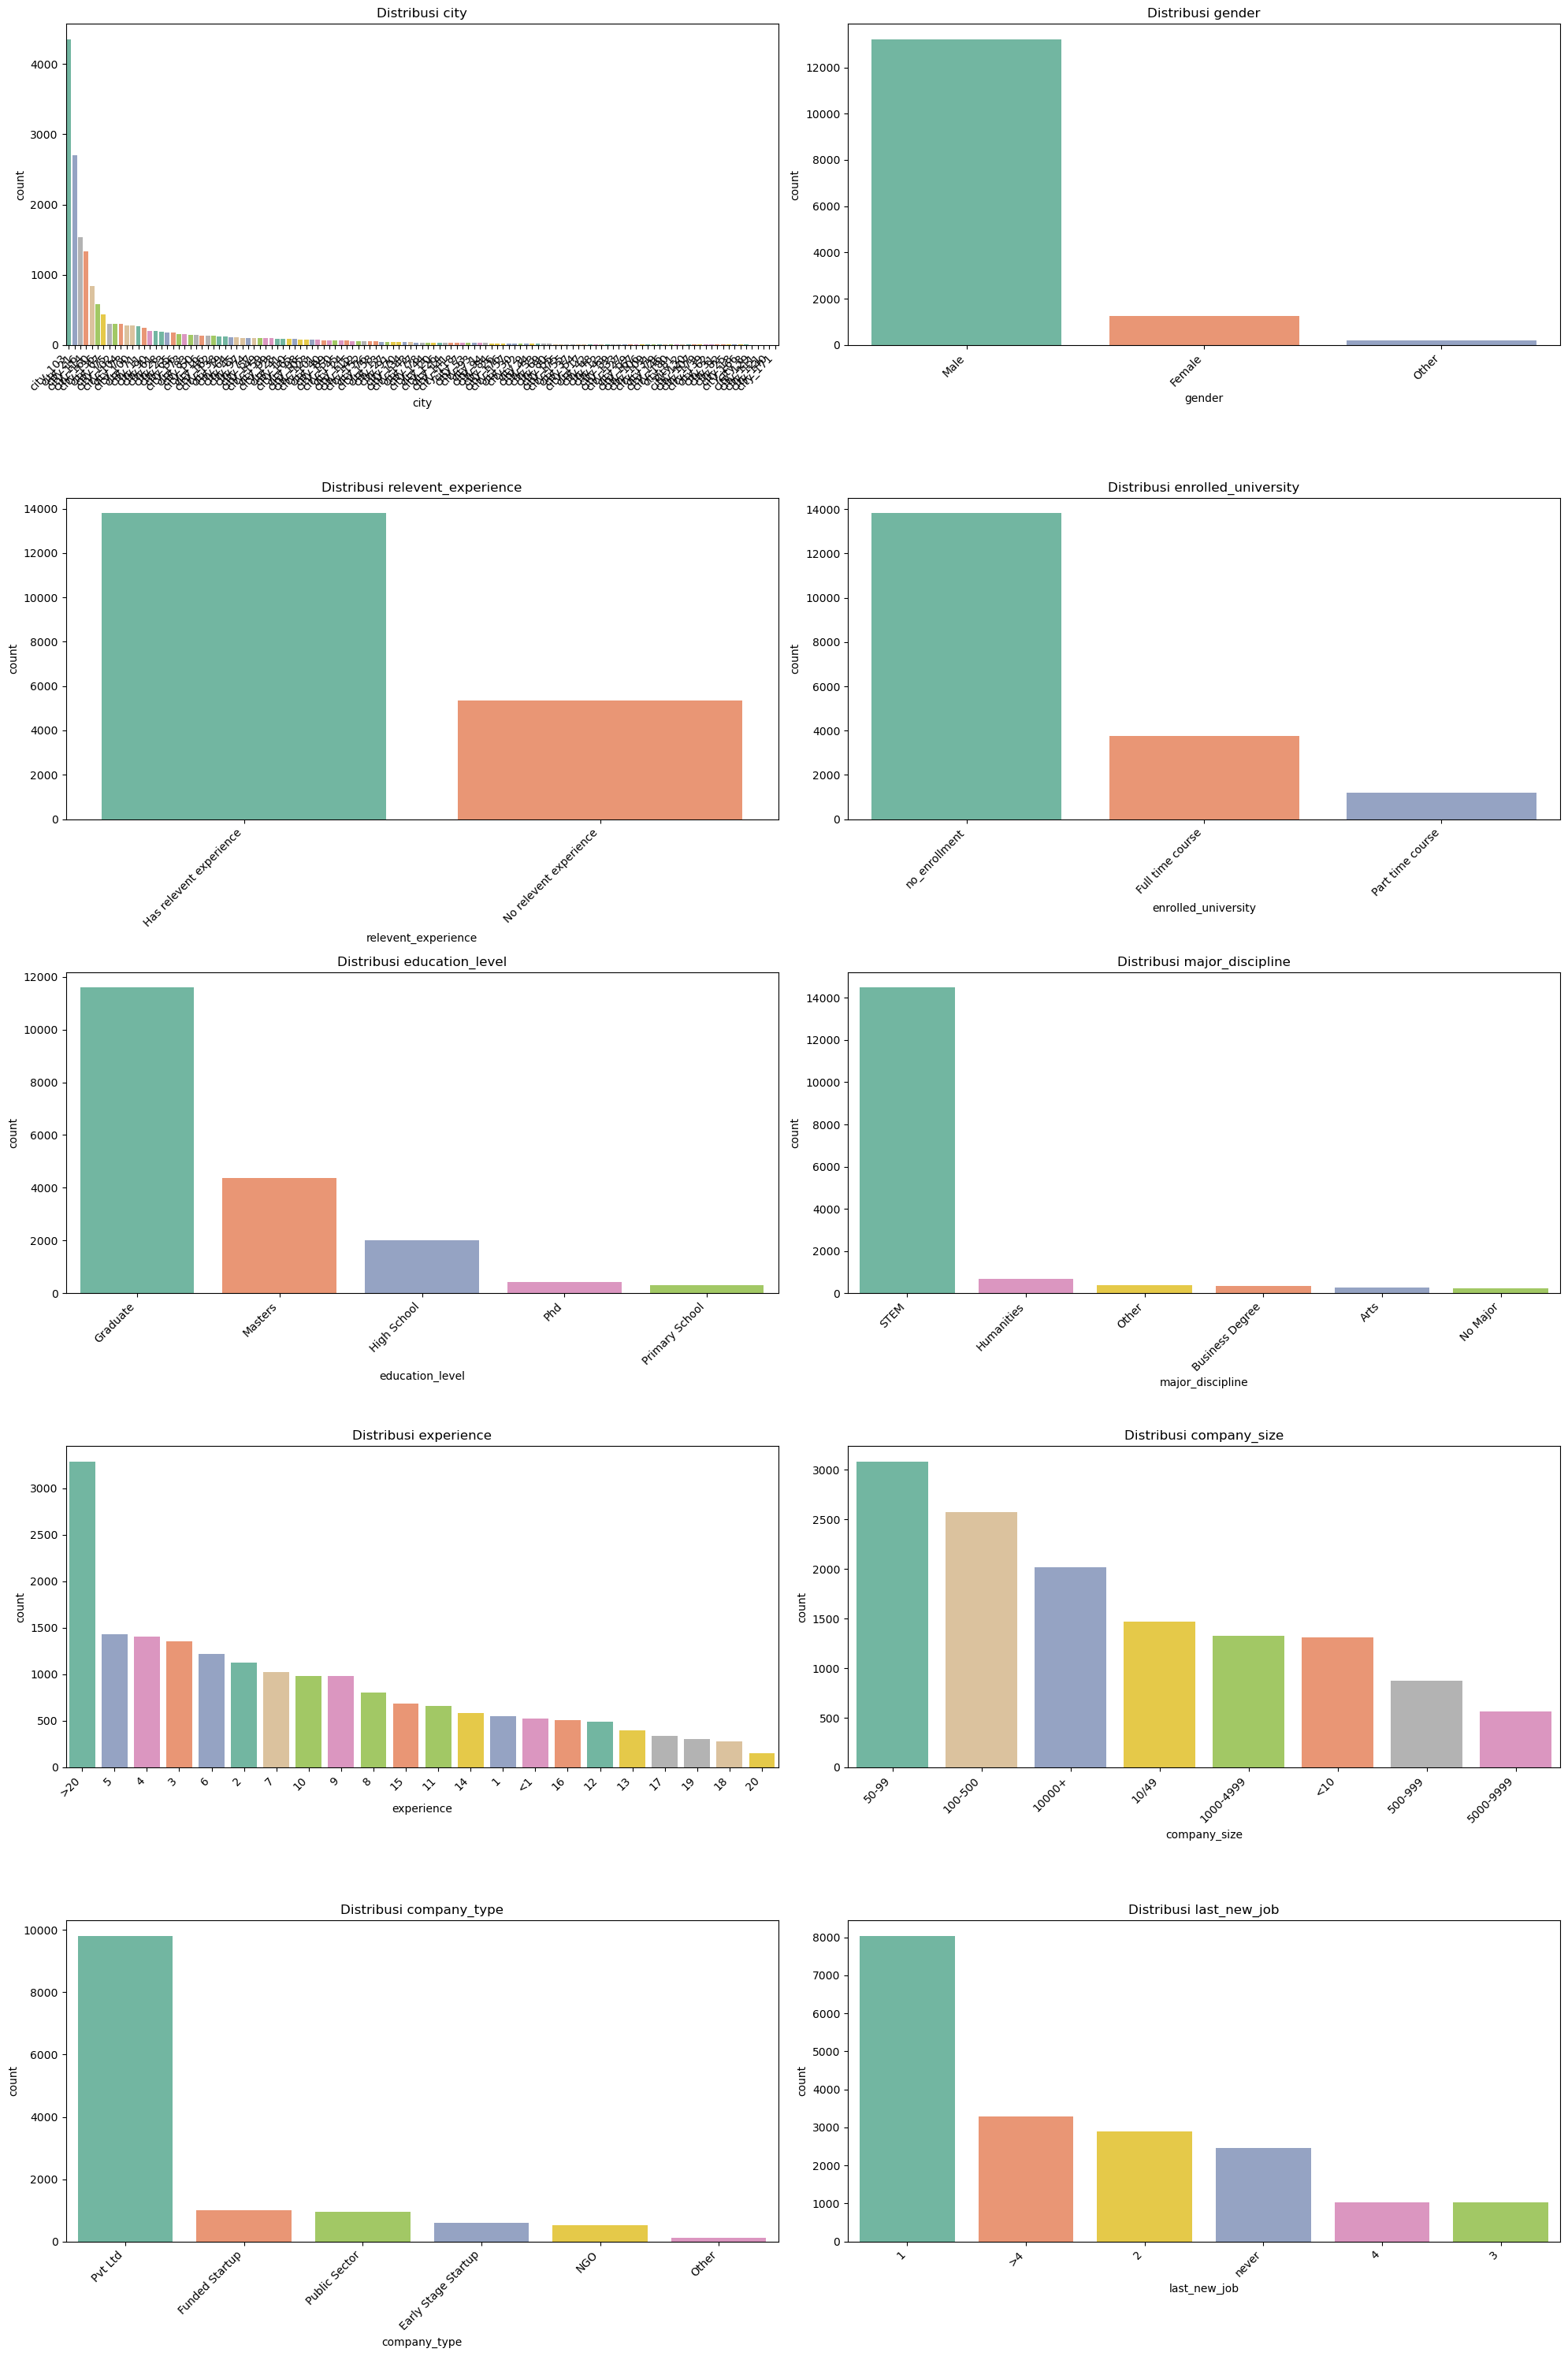

In [9]:
# visualisasi data kategorikal
plt.figure(figsize=(20, 30))

# Loop setiap kolom dan buat countplot
for idx, col in enumerate(kategorikal, 1):
    plt.subplot(5, 2, idx)
    sns.countplot(data=df_train, x=col, hue=col, order=df_train[col].value_counts().index, palette='Set2', legend=False)
    plt.title(f'Distribusi {col}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

plt.show()

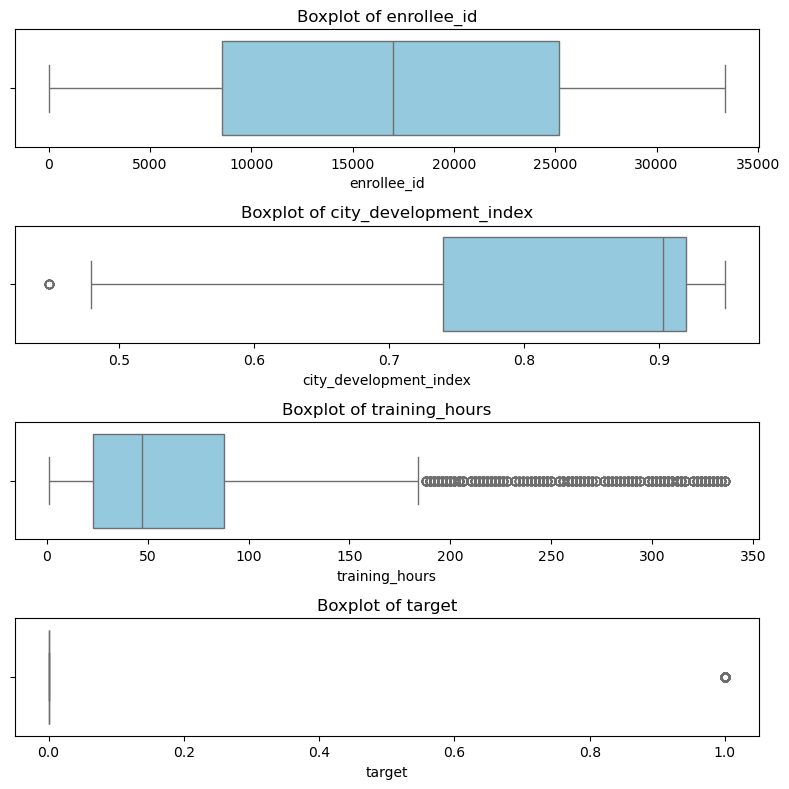

In [10]:
numeric_cols = df_train.select_dtypes(include='number').columns

# Buat subplot satu per satu
plt.figure(figsize=(8, len(numeric_cols) * 2))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(len(numeric_cols), 1, i)
    sns.boxplot(data=df_train, x=col, color='skyblue')
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()

plt.show()


### A. Data Wrangling: Handling Duplicates, Outliers, and Missing Values

In [11]:
# cek duplikat
df_train['enrollee_id'].duplicated().sum()

0

In [12]:
# Handling Outliers

# Hitung Q1 dan Q3
Q1 = df_train['training_hours'].quantile(0.25)
Q3 = df_train['training_hours'].quantile(0.75)
IQR = Q3 - Q1

# Definisikan batas bawah dan atas
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Hapus data yang di luar batas
df_train = df_train[(df_train['training_hours'] >= lower_bound) & (df_train['training_hours'] <= upper_bound)]


In [13]:
# HANDLE MISSING VALUE

# Terapkan str.lower pada setiap kolom menggunakan .apply
df_train = df_train.apply(lambda col: col.map(lambda x: x.lower() if isinstance(x, str) else x))
# kolom gender
df_train['gender'] = df_train['gender'].replace('other', np.nan)

In [14]:
# Isi nilai yang hilang untuk kolom kategoris dengan mode
for col in df_train:
    if df_train[col].isnull().sum() > 0:
        df_train[col] = df_train[col].fillna(df_train[col].mode()[0])

# Label Encoding untuk kolom kategorikal
le = LabelEncoder()
for col in df_train.select_dtypes(include='object').columns:
    df_train[col] = le.fit_transform(df_train[col])

In [15]:
df_train.dtypes

enrollee_id                 int64
city                        int32
city_development_index    float64
gender                      int32
relevent_experience         int32
enrolled_university         int32
education_level             int32
major_discipline            int32
experience                  int32
company_size                int32
company_type                int32
last_new_job                int32
training_hours              int64
target                    float64
dtype: object

In [16]:
df_train.isnull().sum()

enrollee_id               0
city                      0
city_development_index    0
gender                    0
relevent_experience       0
enrolled_university       0
education_level           0
major_discipline          0
experience                0
company_size              0
company_type              0
last_new_job              0
training_hours            0
target                    0
dtype: int64

In [17]:
df_train 

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,5,0.920,1,0,1,0,5,21,4,5,0,36,1.0
1,29725,76,0.776,1,1,1,0,5,6,4,5,4,47,0.0
2,11561,63,0.624,1,1,0,0,5,15,4,5,5,83,0.0
3,33241,14,0.789,1,1,1,0,1,20,4,5,5,52,1.0
4,666,50,0.767,1,0,1,2,5,21,4,1,3,8,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19153,7386,54,0.878,1,1,1,0,2,5,4,5,0,42,1.0
19154,31398,5,0.920,1,0,1,0,5,5,4,5,3,52,1.0
19155,24576,5,0.920,1,0,1,0,5,21,4,5,3,44,0.0
19156,5756,93,0.802,1,0,1,1,5,20,5,5,1,97,0.0


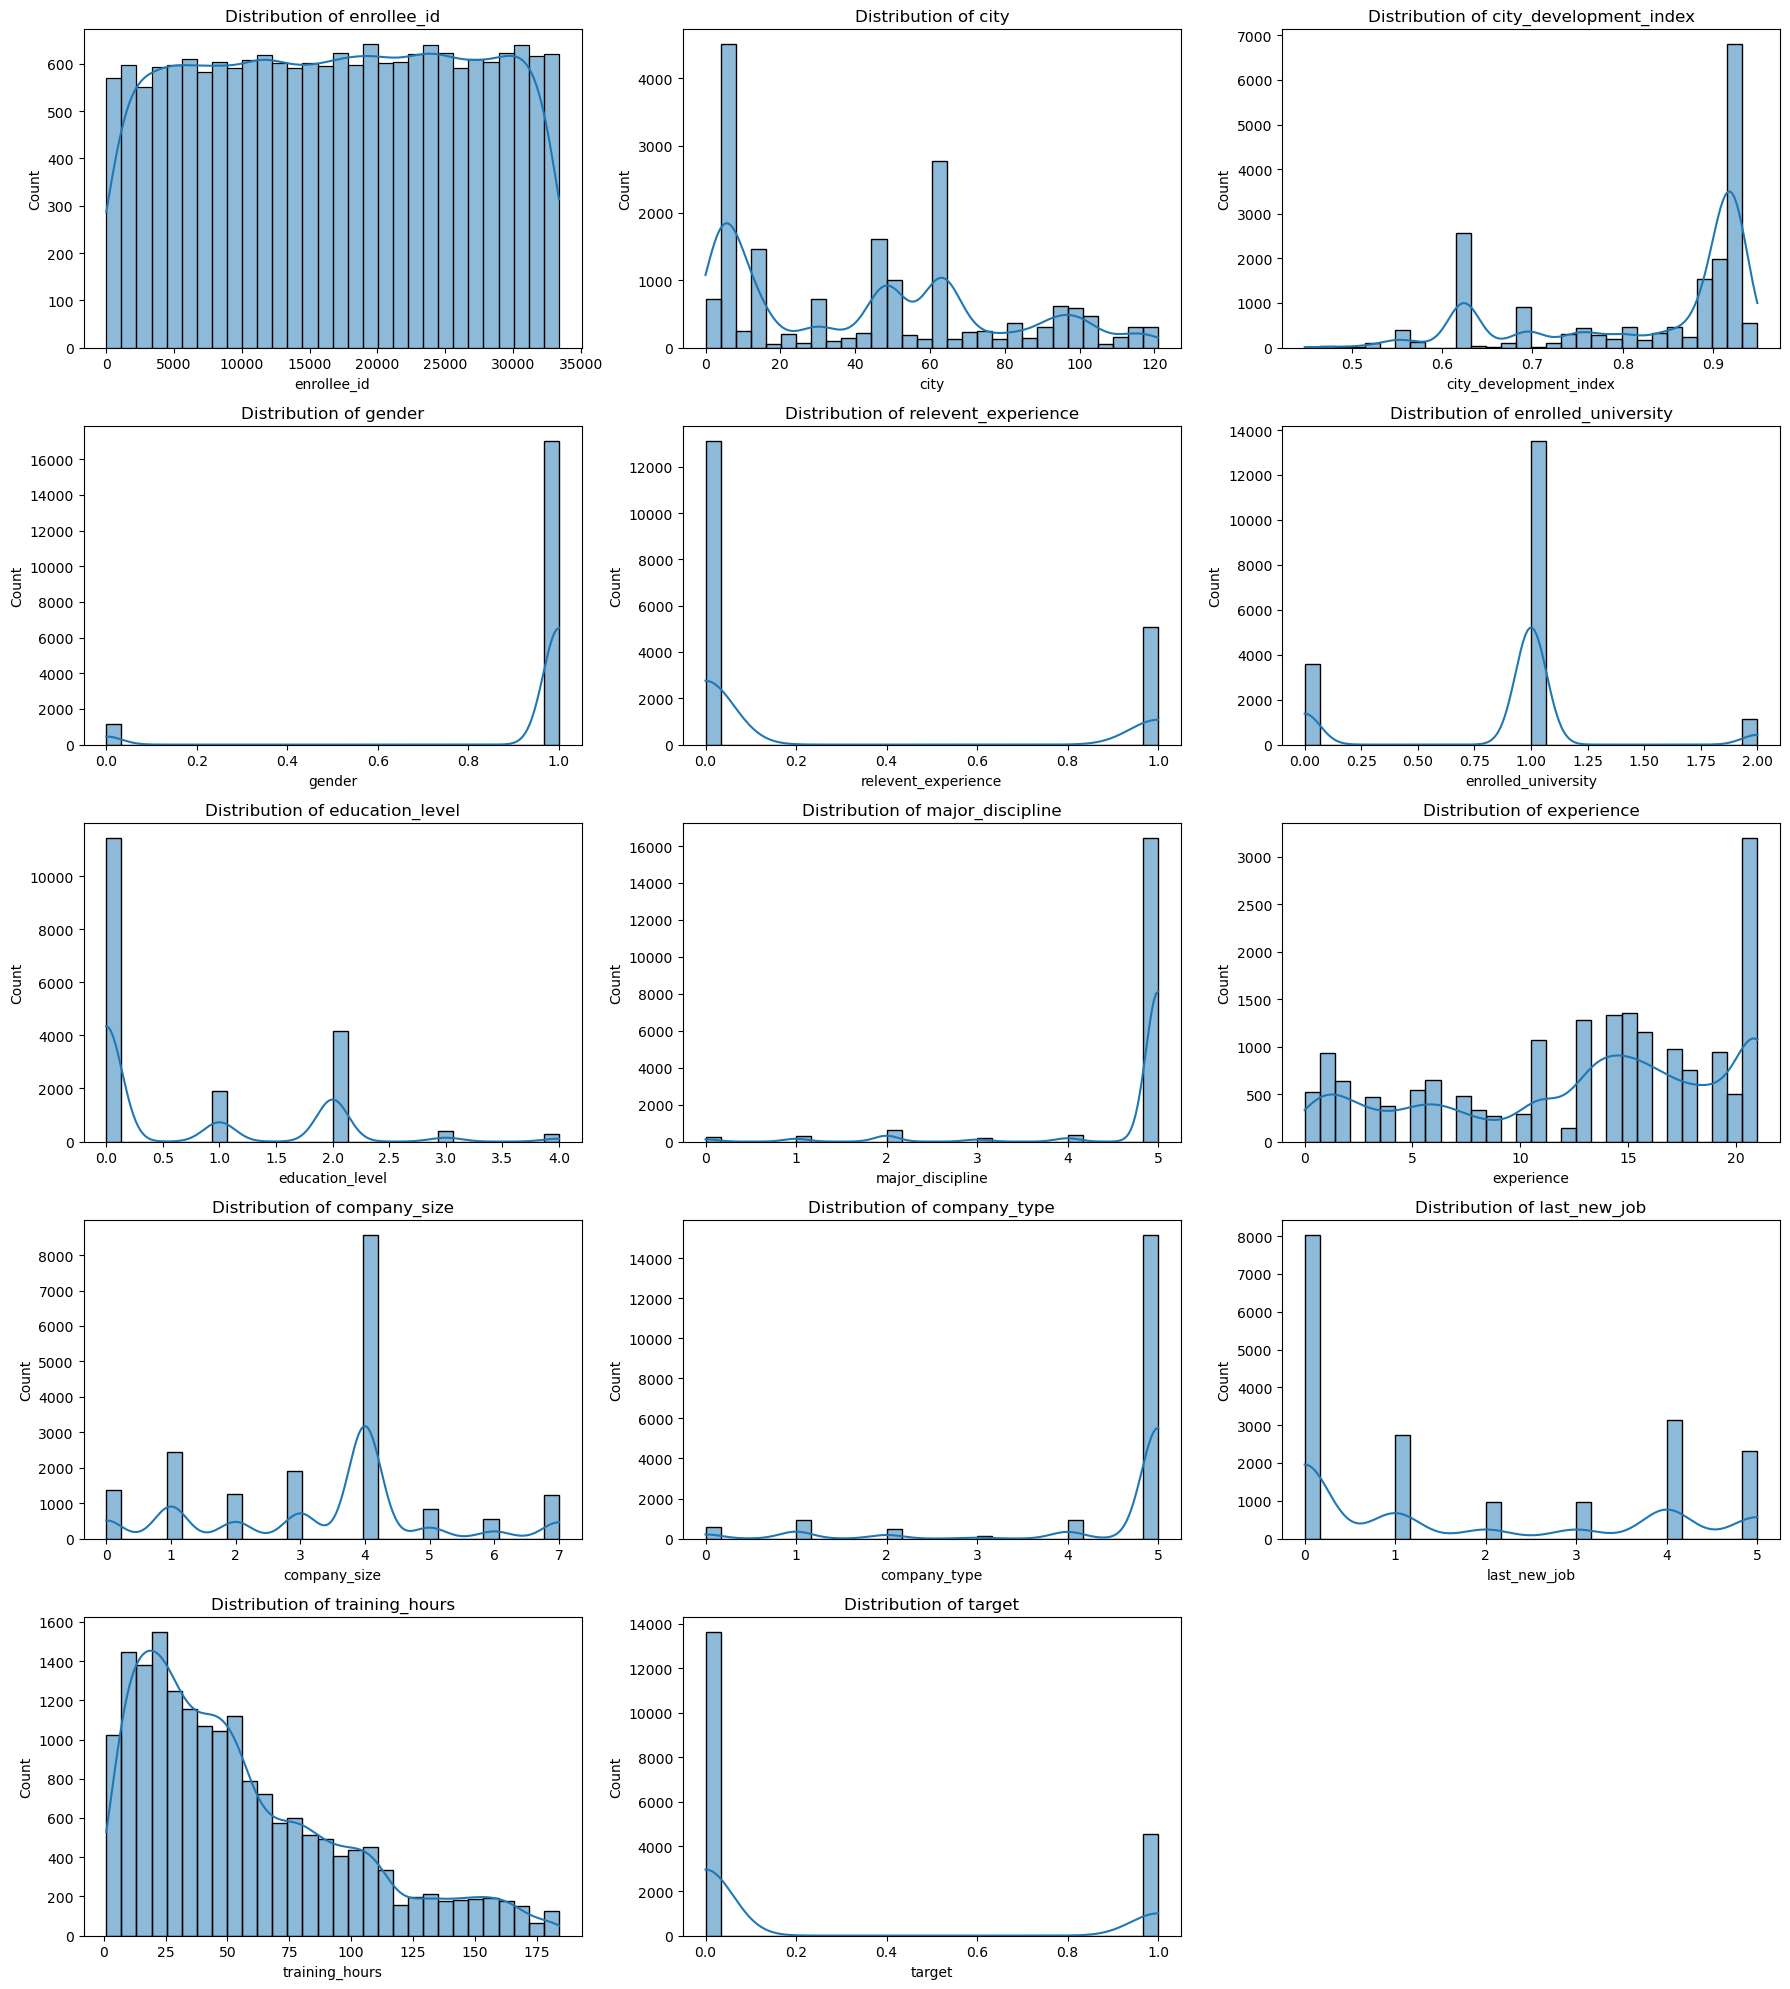

In [18]:
import math

numerik_new = df_train.select_dtypes(include='number').columns

# Hitung baris dan kolom
n = len(numerik_new)
n_cols = 3
n_rows = math.ceil(n / n_cols)

plt.figure(figsize=(6 * n_cols, 4 * n_rows))

for i, col in enumerate(numerik_new, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(df_train[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.tight_layout()

plt.show()


In [19]:
# Menghitung korelasi (metode default adalah Pearson)
correlation_matrix = df_train[numerik_new].corr()

# Melihat matriks korelasi
print("\nMatriks Korelasi:")
print(correlation_matrix)


Matriks Korelasi:
                        enrollee_id      city  city_development_index  \
enrollee_id                1.000000 -0.012223               -0.038308   
city                      -0.012223  1.000000               -0.325815   
city_development_index    -0.038308 -0.325815                1.000000   
gender                    -0.013844  0.026253               -0.032560   
relevent_experience        0.043056  0.005877               -0.058614   
enrolled_university       -0.013419 -0.032858                0.122202   
education_level           -0.027284  0.004144                0.070511   
major_discipline          -0.021527  0.109041               -0.114769   
experience                -0.002386 -0.043007                0.038266   
company_size               0.007366  0.017286               -0.012868   
company_type               0.012510  0.008791               -0.011639   
last_new_job              -0.028590 -0.014369                0.020568   
training_hours             0.006

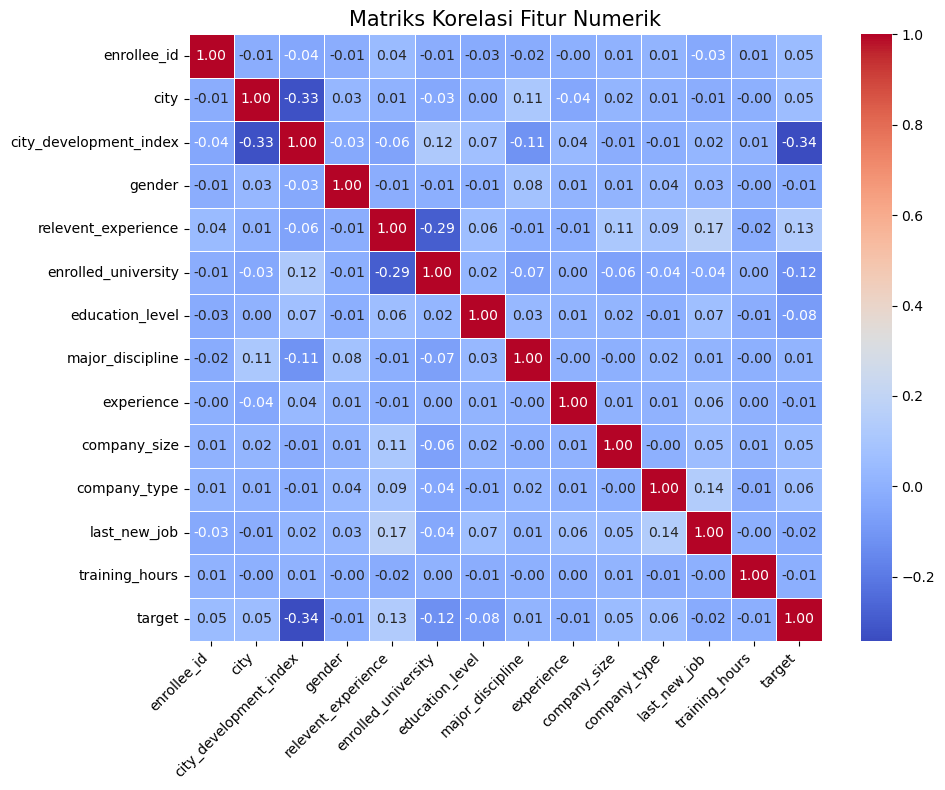

In [20]:
# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title('Matriks Korelasi Fitur Numerik', fontsize=15)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [21]:
df_train['target'].value_counts()
df_train['target'].value_counts(normalize=True)

target
0.0    0.748707
1.0    0.251293
Name: proportion, dtype: float64

In [22]:
# Feature Engineering
df_train['total_years_since_training'] = df_train['experience'] - (df_train['training_hours'] // 50)

def is_big_company(size):
    return 1 if size in [3, 2, 6] else 0

df_train['is_big_company'] = df_train['company_size'].apply(is_big_company)

def education_match(row):
    if row['relevent_experience'] == 1:
        return 0
    elif row['major_discipline'] in [5]:
        return 1
    else:
        return 0
df_train['education_job_match'] = df_train.apply(education_match, axis=1)

city_freq = df_train['city'].value_counts()
df_train['city_frequency'] = df_train['city'].map(city_freq)
df_train['city_opportunity_score'] = df_train['city_development_index'] * df_train['city_frequency']

In [23]:
df_train

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target,total_years_since_training,is_big_company,education_job_match,city_frequency,city_opportunity_score
0,8949,5,0.920,1,0,1,0,5,21,4,5,0,36,1.0,21,0,1,4137,3806.040
1,29725,76,0.776,1,1,1,0,5,6,4,5,4,47,0.0,6,0,0,66,51.216
2,11561,63,0.624,1,1,0,0,5,15,4,5,5,83,0.0,14,0,0,2562,1598.688
3,33241,14,0.789,1,1,1,0,1,20,4,5,5,52,1.0,19,0,0,51,40.239
4,666,50,0.767,1,0,1,2,5,21,4,1,3,8,0.0,21,0,1,125,95.875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19153,7386,54,0.878,1,1,1,0,2,5,4,5,0,42,1.0,5,0,0,145,127.310
19154,31398,5,0.920,1,0,1,0,5,5,4,5,3,52,1.0,4,0,1,4137,3806.040
19155,24576,5,0.920,1,0,1,0,5,21,4,5,3,44,0.0,21,0,1,4137,3806.040
19156,5756,93,0.802,1,0,1,1,5,20,5,5,1,97,0.0,19,0,1,168,134.736


In [24]:
df_train.nunique()

enrollee_id                   18174
city                            122
city_development_index           92
gender                            2
relevent_experience               2
enrolled_university               3
education_level                   5
major_discipline                  6
experience                       22
company_size                      8
company_type                      6
last_new_job                      6
training_hours                  172
target                            2
total_years_since_training       25
is_big_company                    2
education_job_match               2
city_frequency                   80
city_opportunity_score          121
dtype: int64

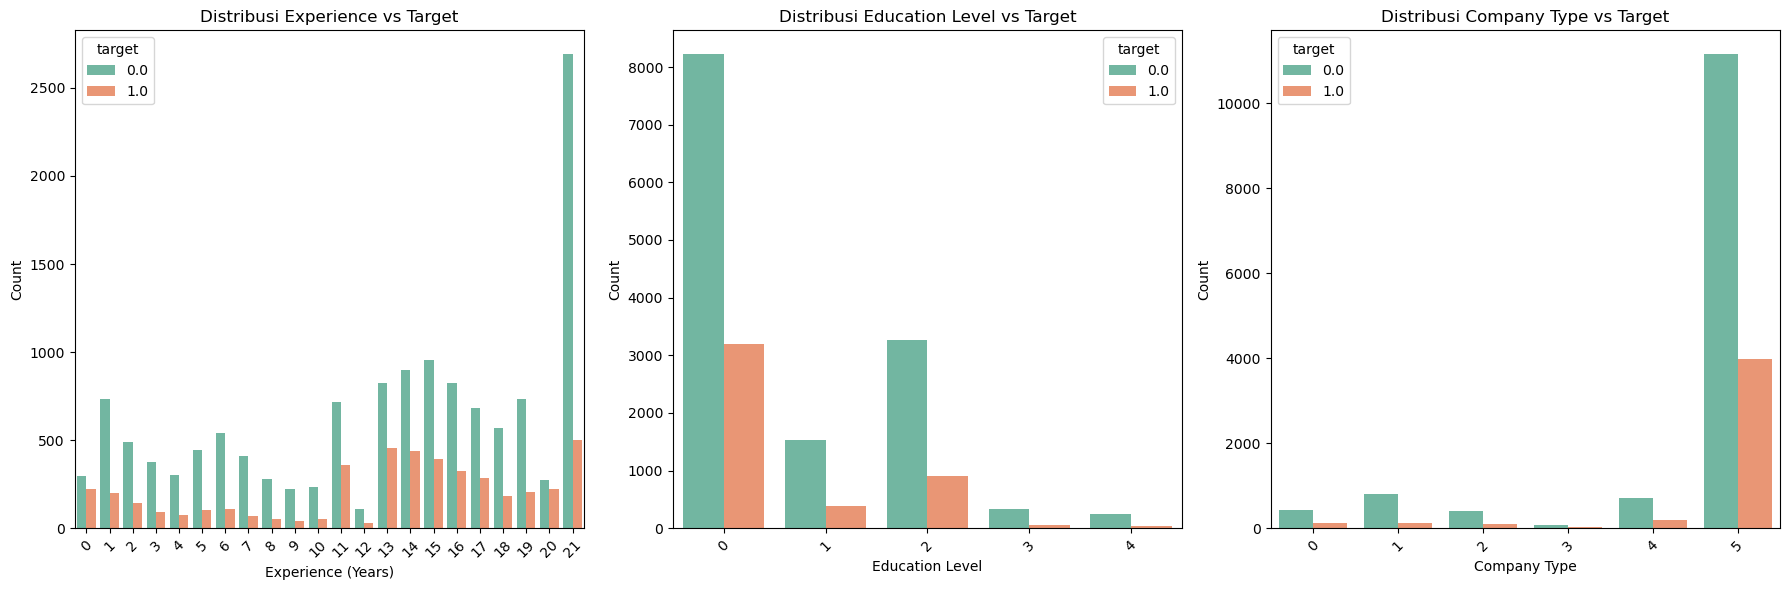

In [25]:
plt.figure(figsize=(18, 6))
# Visualisasi Distribusi Experience vs Target
plt.subplot(1, 3, 1)
sns.countplot(data=df_train, x='experience', hue='target', palette='Set2')
plt.xticks(rotation=45)
plt.title('Distribusi Experience vs Target')
plt.xlabel('Experience (Years)')
plt.ylabel('Count')

# Visualisasi Distribusi Education Level vs Target
plt.subplot(1, 3, 2)
sns.countplot(data=df_train, x='education_level', hue='target', palette='Set2')
plt.xticks(rotation=45)
plt.title('Distribusi Education Level vs Target')
plt.xlabel('Education Level')
plt.ylabel('Count')

# Visualisasi Distribusi Company Type vs Target
plt.subplot(1, 3, 3)
sns.countplot(data=df_train, x='company_type', hue='target', palette='Set2')
plt.xticks(rotation=45)
plt.title('Distribusi Company Type vs Target')
plt.xlabel('Company Type')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

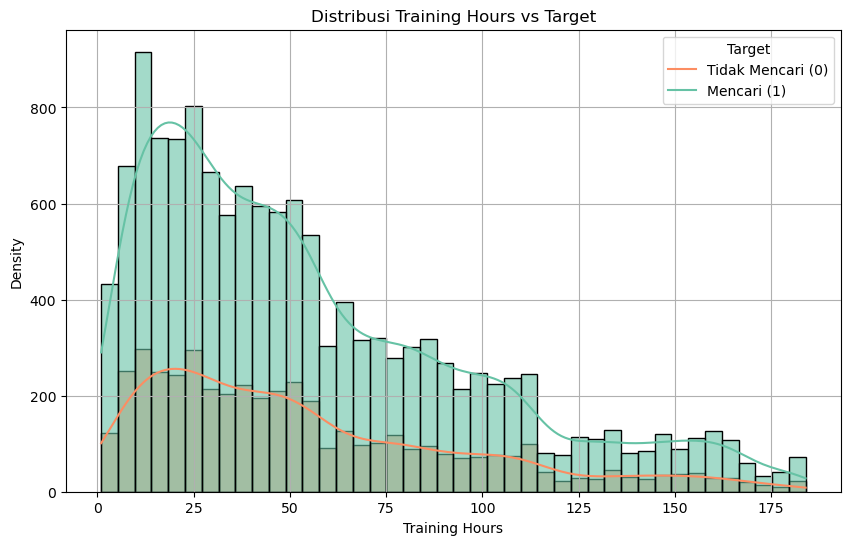

In [26]:
# Visualisasi Distribusi Training Hours vs Target
plt.figure(figsize=(10, 6))
sns.histplot(data=df_train, x='training_hours', hue='target', kde=True, palette='Set2', alpha=0.6)
plt.xlabel('Training Hours')
plt.ylabel('Density')
plt.title('Distribusi Training Hours vs Target')
plt.legend(title='Target', labels=['Tidak Mencari (0)', 'Mencari (1)'])
plt.grid(True)
plt.show()

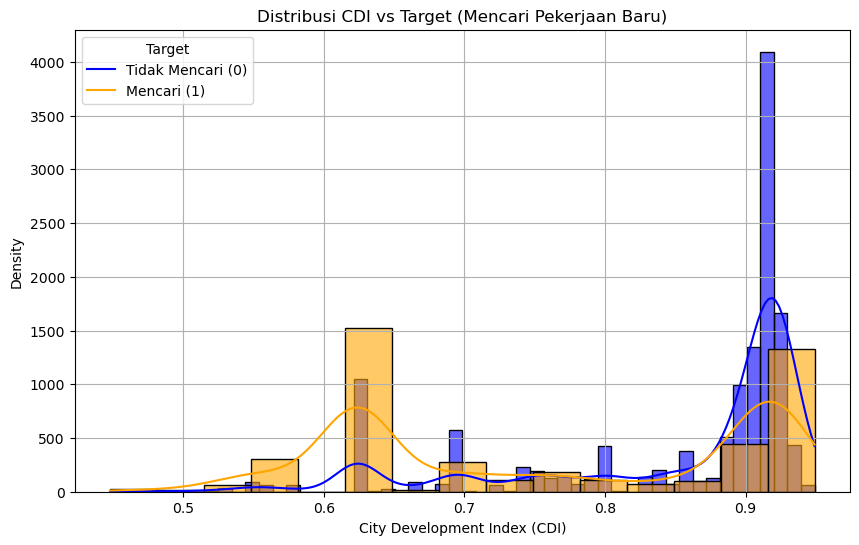

In [27]:
# Visualisasi Distribusi City Development Index (CDI) vs Target
data_fil = df_train
plt.figure(figsize=(10, 6))
sns.histplot(data_fil[data_fil['target'] == 0]['city_development_index'], kde=True, color='blue', label='Target 0', alpha=0.6)
sns.histplot(data_fil[data_fil['target'] == 1]['city_development_index'], kde=True, color='orange', label='Target 1', alpha=0.6)
plt.xlabel('City Development Index (CDI)')
plt.ylabel('Density')
plt.title('Distribusi CDI vs Target (Mencari Pekerjaan Baru)')
plt.legend(title='Target', labels=['Tidak Mencari (0)', 'Mencari (1)'])
plt.grid(True)
plt.show()

# Data Test (aug_test)

In [28]:
df_test

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,32403,city_41,0.827,Male,Has relevent experience,Full time course,Graduate,STEM,9,<10,NaN,1,21
1,9858,city_103,0.920,Female,Has relevent experience,no_enrollment,Graduate,STEM,5,NaN,Pvt Ltd,1,98
2,31806,city_21,0.624,Male,No relevent experience,no_enrollment,High School,NaN,<1,NaN,Pvt Ltd,never,15
3,27385,city_13,0.827,Male,Has relevent experience,no_enrollment,Masters,STEM,11,10/49,Pvt Ltd,1,39
4,27724,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,10000+,Pvt Ltd,>4,72
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2124,1289,city_103,0.920,Male,No relevent experience,no_enrollment,Graduate,Humanities,16,NaN,Public Sector,4,15
2125,195,city_136,0.897,Male,Has relevent experience,no_enrollment,Masters,STEM,18,NaN,NaN,2,30
2126,31762,city_100,0.887,Male,No relevent experience,no_enrollment,Primary School,NaN,3,NaN,Pvt Ltd,never,18
2127,7873,city_102,0.804,Male,Has relevent experience,Full time course,High School,NaN,7,100-500,Public Sector,1,84


In [29]:
df_test.isnull().sum()

enrollee_id                 0
city                        0
city_development_index      0
gender                    508
relevent_experience         0
enrolled_university        31
education_level            52
major_discipline          312
experience                  5
company_size              622
company_type              634
last_new_job               40
training_hours              0
dtype: int64

In [30]:
df_test.dtypes

enrollee_id                 int64
city                       object
city_development_index    float64
gender                     object
relevent_experience        object
enrolled_university        object
education_level            object
major_discipline           object
experience                 object
company_size               object
company_type               object
last_new_job               object
training_hours              int64
dtype: object

In [31]:
df_test.describe()

,enrollee_id,city_development_index,training_hours
count,2129.000000,2129.000000,2129.000000
mean,16861.614843,0.824984,64.983091
std,9576.846029,0.125074,60.238660
min,3.000000,0.448000,1.000000
25%,8562.000000,0.698000,23.000000
50%,16816.000000,0.903000,47.000000
75%,25129.000000,0.920000,86.000000
max,33353.000000,0.949000,334.000000


## Visualisasi Data Test

In [32]:
numerik_test = df_test.select_dtypes(include=['number'])
kategorikal_test = df_test.select_dtypes(include=['object'])

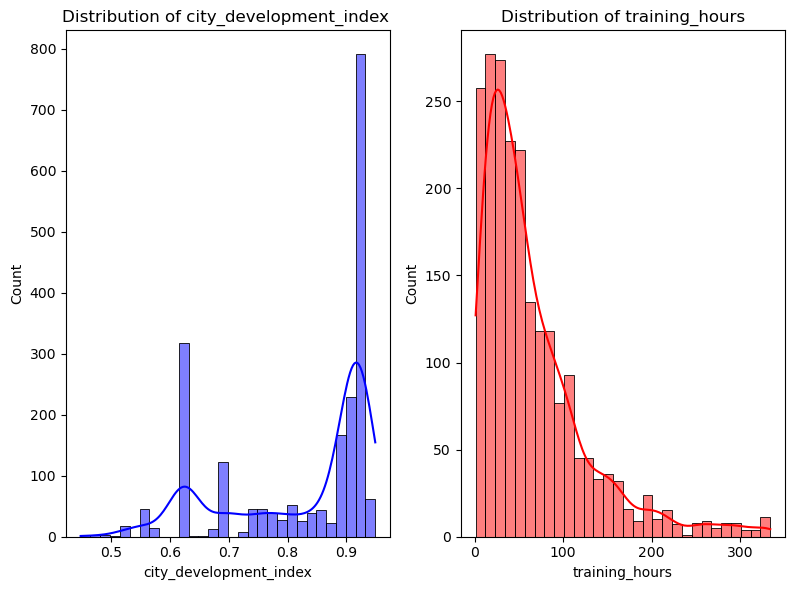

In [33]:
# Visualisasi data numerical
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
sns.histplot(numerik_test['city_development_index'], kde=True, color='blue', bins=30)
plt.title('Distribution of city_development_index ')

plt.subplot(1, 3, 2)
sns.histplot(numerik_test['training_hours'], kde=True, color='red', bins=30)
plt.title('Distribution of training_hours')

plt.tight_layout()
plt.show()


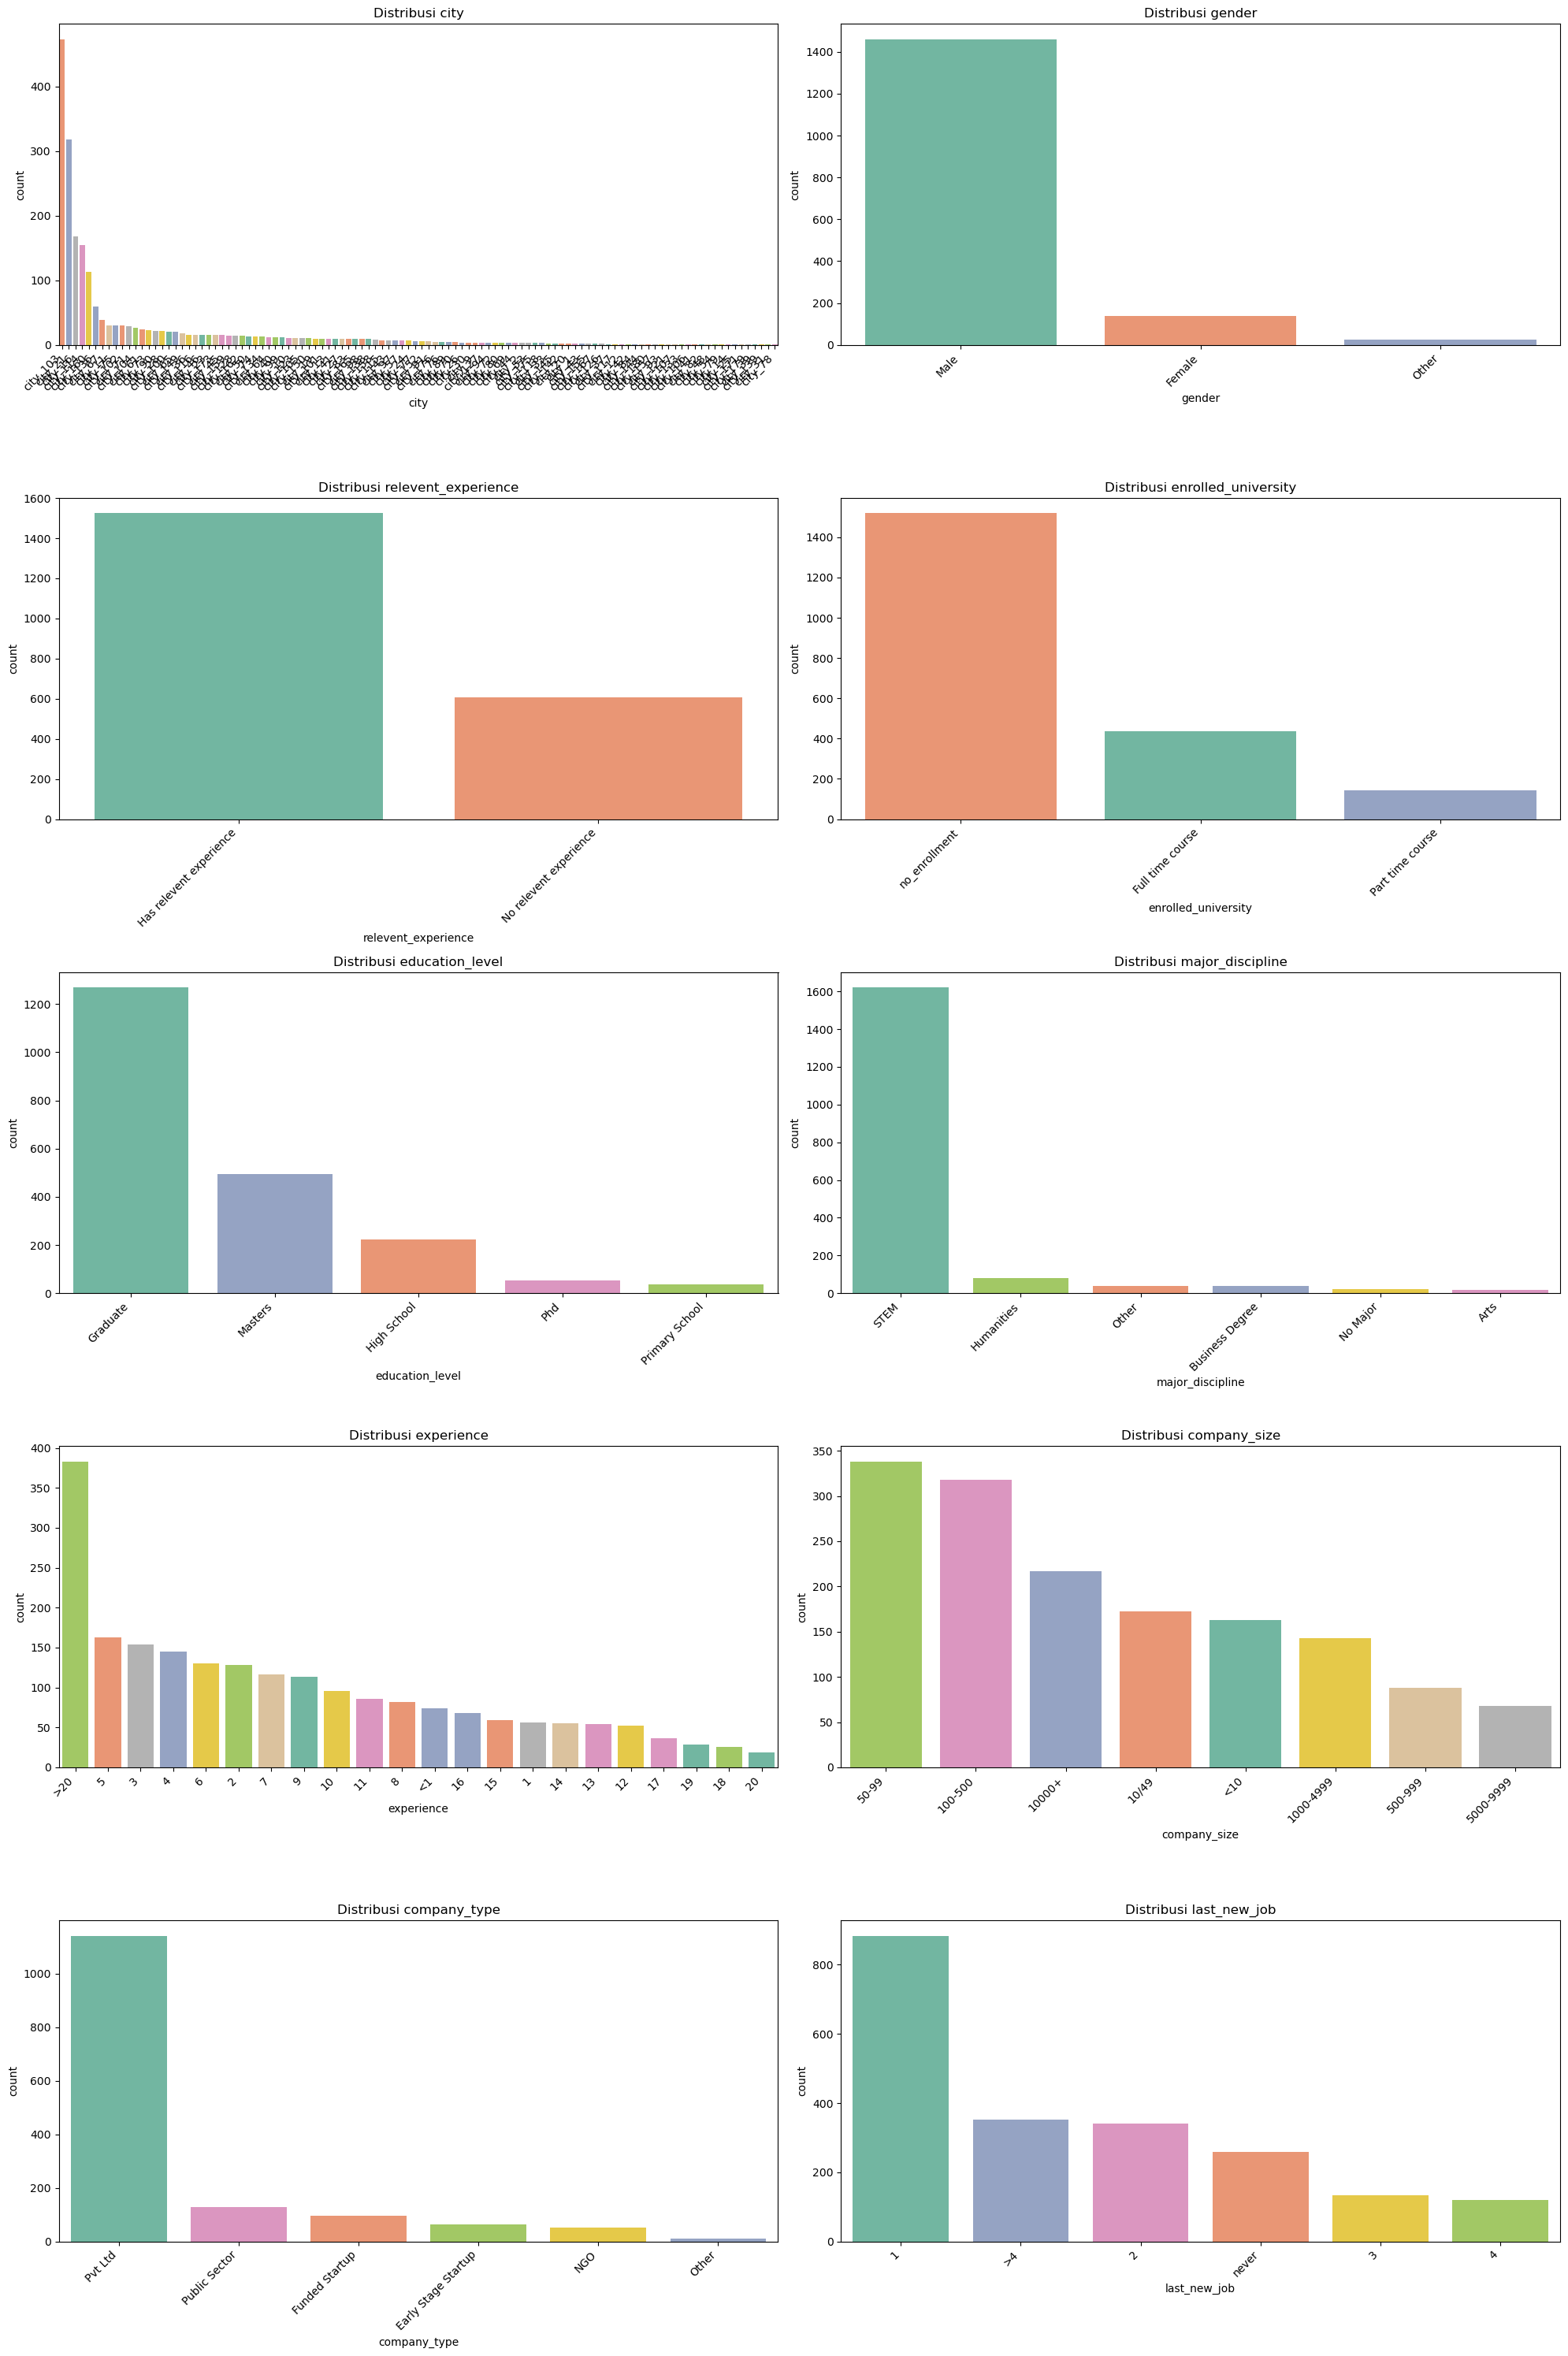

In [34]:
# visualisasi data kategorikal
plt.figure(figsize=(20, 30))

# Loop setiap kolom dan buat countplot
for idx, col in enumerate(kategorikal_test, 1):
    plt.subplot(5, 2, idx)
    sns.countplot(data=df_test, x=col, hue=col, order=df_test[col].value_counts().index, palette='Set2', legend=False)
    plt.title(f'Distribusi {col}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

plt.show()

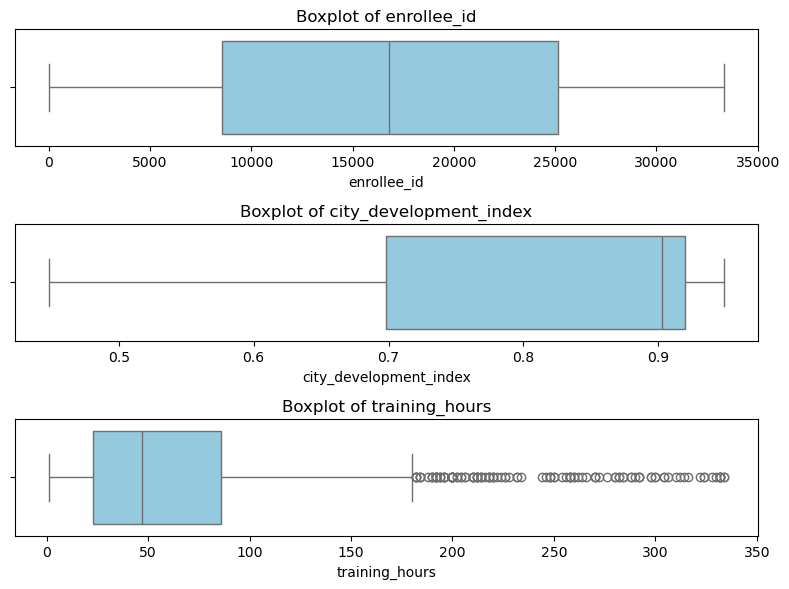

In [35]:
numeric_cols_test = df_test.select_dtypes(include='number').columns

# Buat subplot satu per satu
plt.figure(figsize=(8, len(numeric_cols_test) * 2))

for i, col in enumerate(numeric_cols_test, 1):
    plt.subplot(len(numeric_cols_test), 1, i)
    sns.boxplot(data=df_test, x=col, color='skyblue')
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()

plt.show()


### B. Data Wrangling: Handling Duplicates, Outliers, and Missing Values

In [36]:
# cek duplikat
df_test['enrollee_id'].duplicated().sum()

0

In [37]:
# Terapkan str.lower pada setiap kolom menggunakan .apply
df_test = df_test.apply(lambda col: col.map(lambda x: x.lower() if isinstance(x, str) else x))
# kolom gender
df_test['gender'] = df_test['gender'].replace('other', np.nan)

In [38]:
# Isi nilai yang hilang untuk kolom kategoris dengan mode
for col in df_test:
    if df_test[col].isnull().sum() > 0:
        df_test[col] = df_test[col].fillna(df_test[col].mode()[0])

# Label Encoding untuk kolom kategorikal
le = LabelEncoder()
for col in df_test.select_dtypes(include='object').columns:
    df_test[col] = le.fit_transform(df_test[col])

In [39]:
df_test.dtypes

enrollee_id                 int64
city                        int32
city_development_index    float64
gender                      int32
relevent_experience         int32
enrolled_university         int32
education_level             int32
major_discipline            int32
experience                  int32
company_size                int32
company_type                int32
last_new_job                int32
training_hours              int64
dtype: object

In [40]:
df_test.isnull().sum()

enrollee_id               0
city                      0
city_development_index    0
gender                    0
relevent_experience       0
enrolled_university       0
education_level           0
major_discipline          0
experience                0
company_size              0
company_type              0
last_new_job              0
training_hours            0
dtype: int64

In [41]:
df_test

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,32403,69,0.827,1,0,0,0,5,19,7,5,0,21
1,9858,5,0.920,0,0,1,0,5,15,4,5,0,98
2,31806,55,0.624,1,1,1,1,5,20,4,5,5,15
3,27385,22,0.827,1,0,1,2,5,2,0,5,0,39
4,27724,5,0.920,1,0,1,0,5,21,3,5,4,72
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2124,1289,5,0.920,1,1,1,0,2,7,4,4,3,15
2125,195,25,0.897,1,0,1,2,5,9,4,5,1,30
2126,31762,2,0.887,1,1,1,4,5,13,4,5,5,18
2127,7873,4,0.804,1,0,0,1,5,17,1,4,0,84


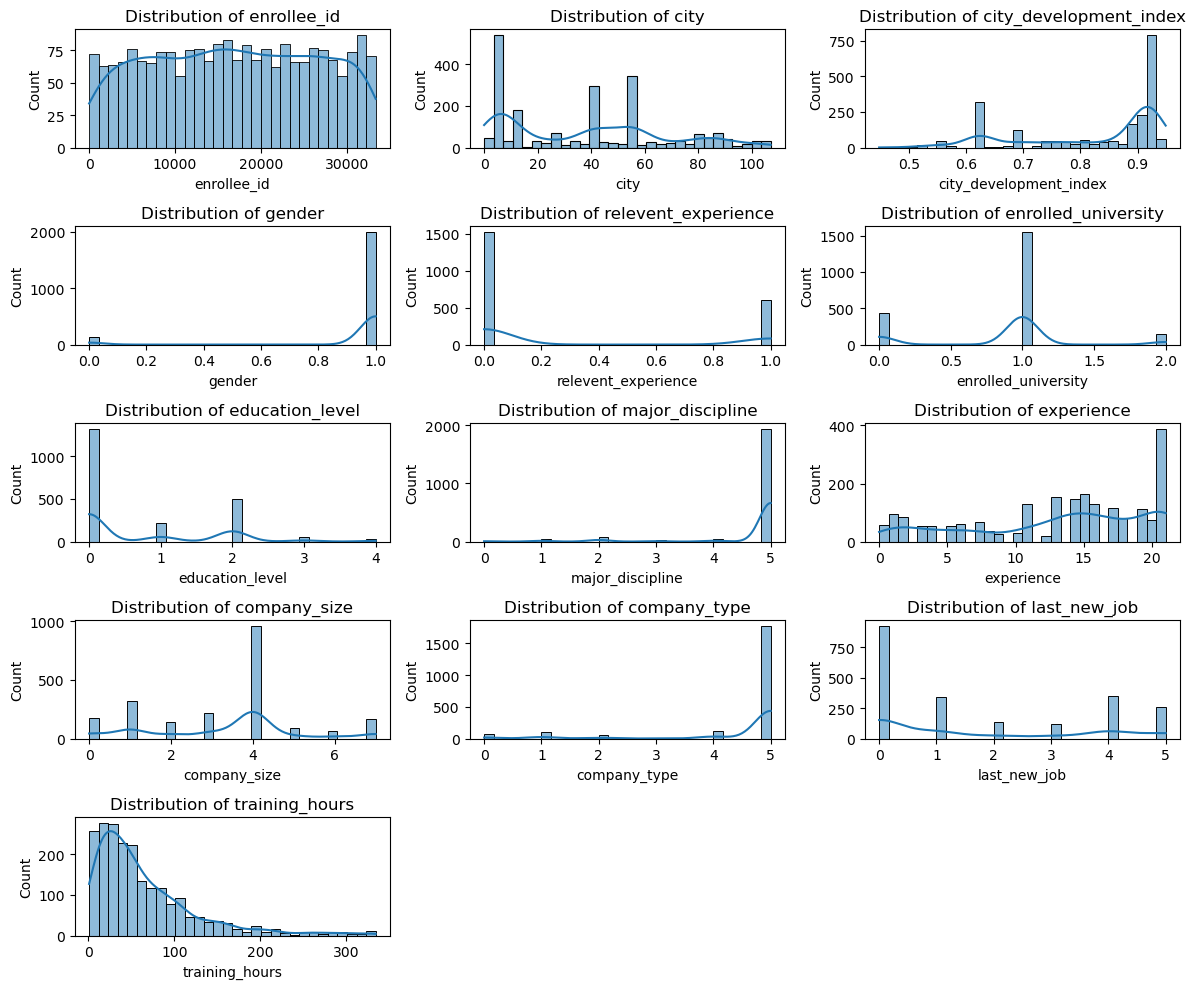

In [42]:
import math

numerik_test_new = df_test.select_dtypes(include='number').columns

# Hitung baris dan kolom
n = len(numerik_test_new)
n_cols = 3
n_rows = math.ceil(n / n_cols)

plt.figure(figsize=(4 * n_cols, 2 * n_rows))

for i, col in enumerate(numerik_test_new, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(df_test[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.tight_layout()

plt.show()


In [43]:
# Menghitung korelasi (metode default adalah Pearson)
correlation_matrix_test = df_test[numerik_test_new].corr()

# Melihat matriks korelasi
print("\nMatriks Korelasi:")
print(correlation_matrix_test)


Matriks Korelasi:
                        enrollee_id      city  city_development_index  \
enrollee_id                1.000000  0.019533               -0.045087   
city                       0.019533  1.000000               -0.323608   
city_development_index    -0.045087 -0.323608                1.000000   
gender                     0.004171 -0.001972               -0.005484   
relevent_experience        0.014973 -0.016469               -0.076364   
enrolled_university        0.008235 -0.018278                0.136239   
education_level           -0.019165 -0.049009                0.110397   
major_discipline          -0.039719  0.088690               -0.114327   
experience                 0.023184 -0.021779                0.059351   
company_size               0.016141  0.007737               -0.024865   
company_type               0.001898  0.035812               -0.021165   
last_new_job               0.002551 -0.050579                0.031503   
training_hours             0.003

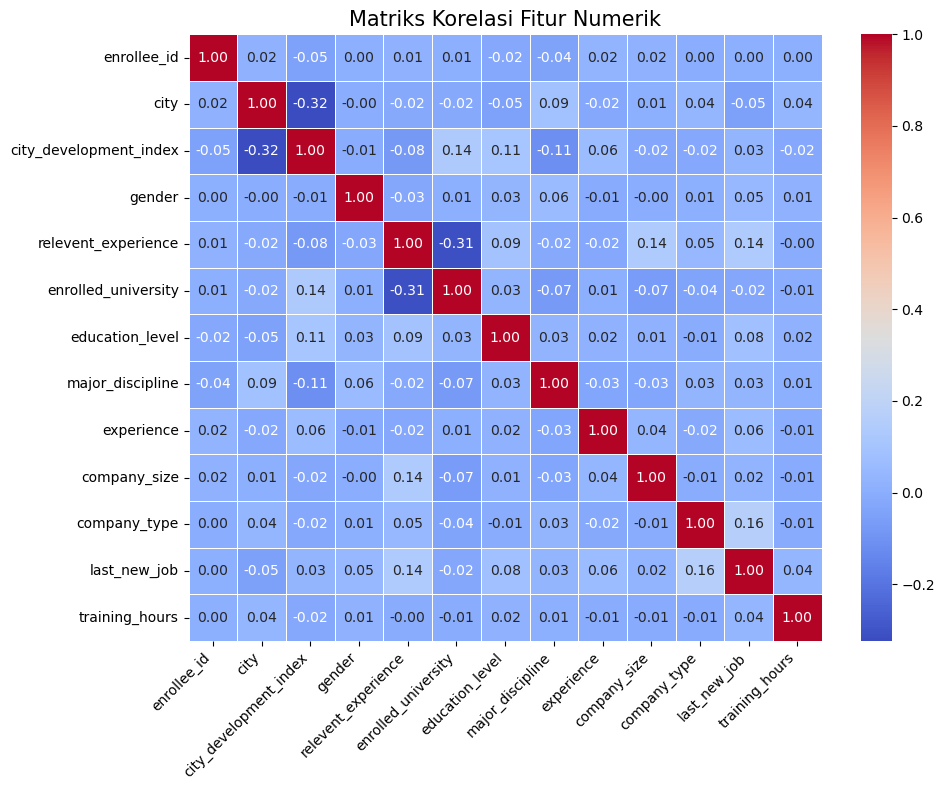

In [44]:
# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_test, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title('Matriks Korelasi Fitur Numerik', fontsize=15)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [45]:
# Feature Engineering
df_test['total_years_since_training'] = df_test['experience'] - (df_test['training_hours'] // 50)

def is_big_company(size):
    return 1 if size in [3, 2, 6] else 0

df_test['is_big_company'] = df_test['company_size'].apply(is_big_company)

def education_match(row):
    if row['relevent_experience'] == 1:
        return 0
    elif row['major_discipline'] in [5]:
        return 1
    else:
        return 0
df_test['education_job_match'] = df_test.apply(education_match, axis=1)

city_freq_test = df_test['city'].value_counts()
df_test['city_frequency'] = df_test['city'].map(city_freq_test)
df_test['city_opportunity_score'] = df_test['city_development_index'] * df_test['city_frequency']



# Modeling

In [46]:
df_train

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target,total_years_since_training,is_big_company,education_job_match,city_frequency,city_opportunity_score
0,8949,5,0.920,1,0,1,0,5,21,4,5,0,36,1.0,21,0,1,4137,3806.040
1,29725,76,0.776,1,1,1,0,5,6,4,5,4,47,0.0,6,0,0,66,51.216
2,11561,63,0.624,1,1,0,0,5,15,4,5,5,83,0.0,14,0,0,2562,1598.688
3,33241,14,0.789,1,1,1,0,1,20,4,5,5,52,1.0,19,0,0,51,40.239
4,666,50,0.767,1,0,1,2,5,21,4,1,3,8,0.0,21,0,1,125,95.875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19153,7386,54,0.878,1,1,1,0,2,5,4,5,0,42,1.0,5,0,0,145,127.310
19154,31398,5,0.920,1,0,1,0,5,5,4,5,3,52,1.0,4,0,1,4137,3806.040
19155,24576,5,0.920,1,0,1,0,5,21,4,5,3,44,0.0,21,0,1,4137,3806.040
19156,5756,93,0.802,1,0,1,1,5,20,5,5,1,97,0.0,19,0,1,168,134.736


In [47]:
df_test

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,total_years_since_training,is_big_company,education_job_match,city_frequency,city_opportunity_score
0,32403,69,0.827,1,0,0,0,5,19,7,5,0,21,19,0,1,9,7.443
1,9858,5,0.920,0,0,1,0,5,15,4,5,0,98,14,0,1,473,435.160
2,31806,55,0.624,1,1,1,1,5,20,4,5,5,15,20,0,0,318,198.432
3,27385,22,0.827,1,0,1,2,5,2,0,5,0,39,2,0,1,10,8.270
4,27724,5,0.920,1,0,1,0,5,21,3,5,4,72,20,1,1,473,435.160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2124,1289,5,0.920,1,1,1,0,2,7,4,4,3,15,7,0,0,473,435.160
2125,195,25,0.897,1,0,1,2,5,9,4,5,1,30,9,0,1,60,53.820
2126,31762,2,0.887,1,1,1,4,5,13,4,5,5,18,13,0,0,21,18.627
2127,7873,4,0.804,1,0,0,1,5,17,1,4,0,84,16,0,1,30,24.120


In [48]:
df_train.nunique()

enrollee_id                   18174
city                            122
city_development_index           92
gender                            2
relevent_experience               2
enrolled_university               3
education_level                   5
major_discipline                  6
experience                       22
company_size                      8
company_type                      6
last_new_job                      6
training_hours                  172
target                            2
total_years_since_training       25
is_big_company                    2
education_job_match               2
city_frequency                   80
city_opportunity_score          121
dtype: int64

In [49]:
df_test.nunique()

enrollee_id                   2129
city                           108
city_development_index          81
gender                           2
relevent_experience              2
enrolled_university              3
education_level                  5
major_discipline                 6
experience                      22
company_size                     8
company_type                     6
last_new_job                     6
training_hours                 223
total_years_since_training      28
is_big_company                   2
education_job_match              2
city_frequency                  32
city_opportunity_score         100
dtype: int64

In [50]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import joblib  # Import joblib

# Fitur dan target
X = df_train.drop(['target', 'enrollee_id', 'city_frequency'], axis=1)
y = df_train['target']

# Standardisasi fitur (scaling sangat penting untuk Logistic Regression)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Penanganan class imbalance
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_scaled, y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# Model inisialisasi (perbaikan max_iter + hapus use_label_encoder)
models = {
    'Logistic Regression': LogisticRegression(max_iter=2000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(eval_metric='logloss')
}

# Evaluasi model
results = []
best_model = None  # Placeholder for the best model
best_model_name = None  # Placeholder for the best model name
best_f1_score = 0  # Track the best F1-Score

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    results.append({
        'Model': name,
        'Accuracy': round(accuracy_score(y_test, y_pred), 4),
        'Precision': round(precision_score(y_test, y_pred), 4),
        'Recall': round(recall_score(y_test, y_pred), 4),
        'F1-Score': round(f1, 4)
    })
    
    # Track the best model
    if f1 > best_f1_score:
        best_f1_score = f1
        best_model = model
        best_model_name = name

# Save the best model
if best_model:
    joblib.dump(best_model, f"{best_model_name}_model.joblib")
    print(f"Model terbaik '{best_model_name}' disimpan sebagai {best_model_name}_model.joblib")

# Tampilkan hasil evaluasi
results_df = pd.DataFrame(results)
print(results_df)

c:\Users\affan\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\affan\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\affan\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\affan\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\affan\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreatePro

Model terbaik 'Random Forest' disimpan sebagai Random Forest_model.joblib
                 Model  Accuracy  Precision  Recall  F1-Score
0  Logistic Regression    0.7066     0.7291  0.6651    0.6956
1        Decision Tree    0.7692     0.7721  0.7693    0.7707
2        Random Forest    0.8435     0.8460  0.8429    0.8445
3              XGBoost    0.8301     0.8446  0.8123    0.8282


In [51]:
# Uji model dengan data baru
print("\nMenguji model dengan data baru...")

# Buat DataFrame dari data baru
new_df = df_test.drop(['enrollee_id', 'city_frequency'], axis=1)

# Standardisasi data baru
new_df_scaled = scaler.transform(new_df)

# Load the best model (optional)
best_model = joblib.load(f"{best_model_name}_model.joblib")

# Prediksi menggunakan model terbaik
print(f"Model terbaik berdasarkan F1-Score: {best_model_name}")
new_predictions = best_model.predict(new_df_scaled)
new_prob = best_model.predict_proba(new_df_scaled)




Menguji model dengan data baru...
Model terbaik berdasarkan F1-Score: Random Forest


In [52]:
prediction_df = pd.DataFrame({
    'Sample': [f"Sampel {i+1}" for i in range(len(new_predictions))],
    'Prediction': ['Akan resign' if pred == 1 else 'Tidak akan resign' for pred in new_predictions],
    'Resignation_Probability': [round(prob[1], 4) for prob in new_prob]
})

In [53]:
prediction_df

,Sample,Prediction,Resignation_Probability
0,Sampel 1,Tidak akan resign,0.20
1,Sampel 2,Akan resign,0.52
2,Sampel 3,Akan resign,0.68
3,Sampel 4,Tidak akan resign,0.20
4,Sampel 5,Tidak akan resign,0.07
...,...,...,...
2124,Sampel 2125,Tidak akan resign,0.33
2125,Sampel 2126,Tidak akan resign,0.25
2126,Sampel 2127,Tidak akan resign,0.08
2127,Sampel 2128,Tidak akan resign,0.10
